# Accelerometer Weight Configuration Classifier

By `Abhijeet Srivastav`

**Aim**

Predicting the type of weight configuration of blade based on Motor fault detection dataset.

**Dataset Information**
- Dataset has 153000 rows and 5 columns
- Dataset [Source](https://archive.ics.uci.edu/ml/datasets/Accelerometer#)


**Devices used**

Akasa AK-FN059 12cm Viper cooling fan (Generate the vibrations)
MMA8452Q accelerometer (Measure vibration)

**Data Collection Method**

17 rotation speeds were set up, ranging from 20% to 100% of the cooler maximum speed at 5% intervals; for the three weight distribution configurations in the cooler blades. Note that the Akasa AK-FN059 cooler has 1900 rpm of max rotation speed.

The vibration measurements were collected at a frequency of 20 ms for 1 min for each percentage, generating 3000 records per speed. Thus, in total, 153,000 vibration records were collected from the simulation model.

**Attribute Information**

1. wconfid: Weight configuration ID 
    - 'Red' encoded as 1 is normal configuration
    - 'Blue' encoded as 2 is perpendicular configuration
    - 'Green' encoded as 3 is opposite configuration
2. pctid: Cooler fan RPM speed percentage ID (in percentage)
3. x: Accelerometer x value
4. y: Accelerometer y value
5. z: Accelerometer z value

**Target Feature**
- Our target is to predict the Weight configuration ID (wconfid)

# 0. Required Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Data Collection

In [3]:
df = pd.read_csv('../../Dataset/accelerometer.csv')

In [4]:
df.head()

,wconfid,pctid,x,y,z
0,1,20,1.004,0.090,-0.125
1,1,20,1.004,-0.043,-0.125
2,1,20,0.969,0.090,-0.121
3,1,20,0.973,-0.012,-0.137
4,1,20,1.000,-0.016,-0.121


# 2. Data Preprocessing - First Pass

In [5]:
df.describe()

,wconfid,pctid,x,y,z
count,153000.000000,153000.000000,153000.000000,153000.000000,153000.000000
mean,2.000000,60.000000,0.995622,0.005351,-0.117769
std,0.816499,24.494977,0.773958,0.742602,0.517008
min,1.000000,20.000000,-8.000000,-8.000000,-5.867000
25%,1.000000,40.000000,0.945000,-0.078000,-0.172000
50%,2.000000,60.000000,0.992000,0.008000,-0.125000
75%,3.000000,80.000000,1.039000,0.105000,-0.066000
max,3.000000,100.000000,7.996000,7.996000,6.086000


## 2.1. Checking for Null values

<AxesSubplot:>

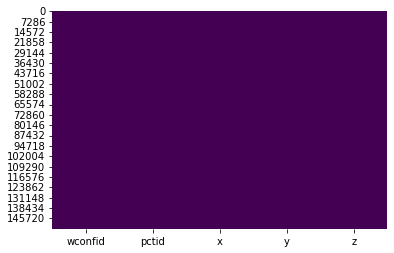

In [6]:
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)

In [7]:
df.isnull().any()

wconfid    False
pctid      False
x          False
y          False
z          False
dtype: bool

**Observation:** Their are no Null values in any of the columns.

## 2.2. Checking for NA values

<AxesSubplot:>

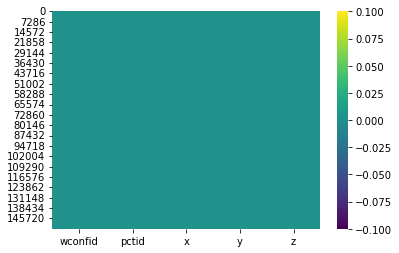

In [8]:
sns.heatmap(df.isna(), cmap='viridis', cbar=True)

In [9]:
df.isna().any()

wconfid    False
pctid      False
x          False
y          False
z          False
dtype: bool

**Observation:** Their are no NA values in any of the columns.

### 2.3. Checking the data type of features

In [10]:
df.dtypes

wconfid      int64
pctid        int64
x          float64
y          float64
z          float64
dtype: object

**Observation:** All features are in appropriate data type.

# 3. Exploratory Data Analysis

In [11]:
df

,wconfid,pctid,x,y,z
0,1,20,1.004,0.090,-0.125
1,1,20,1.004,-0.043,-0.125
2,1,20,0.969,0.090,-0.121
3,1,20,0.973,-0.012,-0.137
4,1,20,1.000,-0.016,-0.121
...,...,...,...,...,...
152995,3,100,1.051,0.090,-0.262
152996,3,100,0.918,0.039,-0.129
152997,3,100,1.156,-0.094,-0.227
152998,3,100,0.934,0.203,-0.172


## 3.1. Detecting Outliers using Box Plot

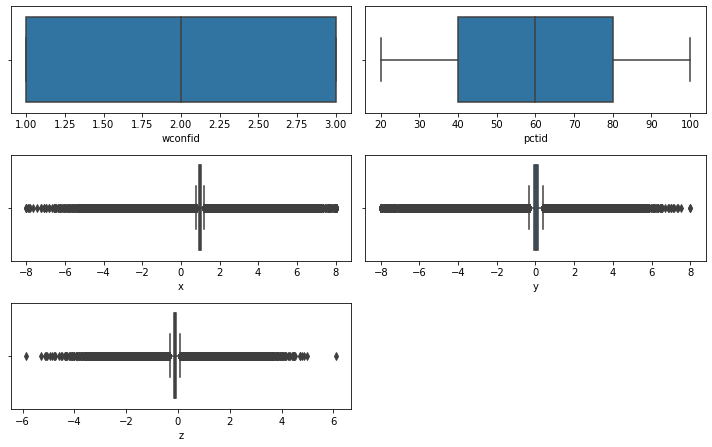

In [12]:
n = 1
plt.figure(figsize=(10, 10))
for feature in df.columns:
    plt.subplot(5, 2, n)
    n += 1
    sns.boxplot(df[feature])
    plt.tight_layout()

**Observation:** 
- Outliers detected in x, y, z feature in visual inspection.
- We don't need to remove these outliers as they are simply the readings of accelerometer through the 3D space (as suggested in research paper)

## 3.2. Correlation of features

In [13]:
df.corr()

,wconfid,pctid,x,y,z
wconfid,1.000000e+00,1.035463e-15,-0.006065,0.005371,0.002228
pctid,1.035463e-15,1.000000e+00,0.002128,0.002882,0.008964
x,-6.065048e-03,2.128479e-03,1.000000,0.021137,-0.091164
y,5.371007e-03,2.881727e-03,0.021137,1.000000,-0.027716
z,2.228362e-03,8.964497e-03,-0.091164,-0.027716,1.000000


<AxesSubplot:>

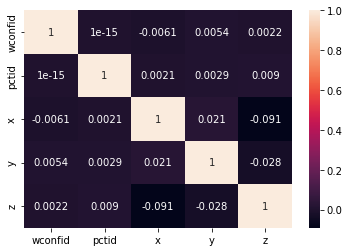

In [14]:
sns.heatmap(df.corr(), annot=True)

**Observation:** None of the features are highly correlated.

# 4. Analytical Observation

## 4.1. How many readings of each of the wconfid ?

<AxesSubplot:xlabel='wconfid', ylabel='Count'>

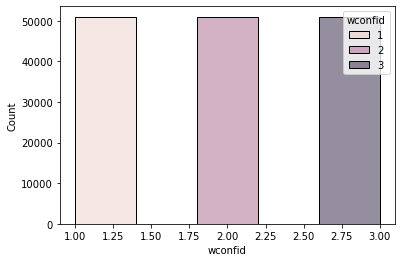

In [15]:
sns.histplot(df, x='wconfid', hue='wconfid', bins=5)

In [16]:
df['wconfid'].value_counts()

1    51000
2    51000
3    51000
Name: wconfid, dtype: int64

**Observation:** 51000 readings for each, Red(1), Blue(2), Green(3) weight configuration is present.

## 4.2.Distribution of Target with input features

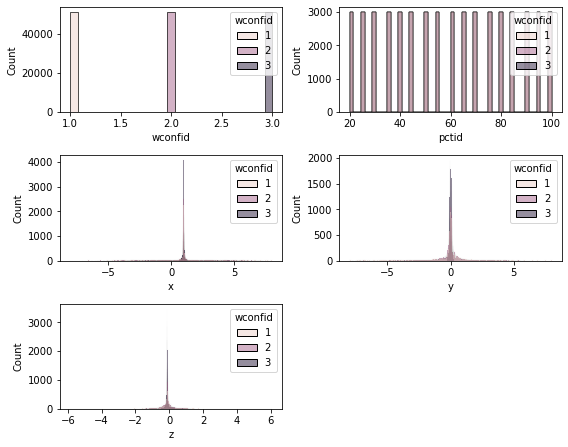

In [17]:
n = 1
plt.figure(figsize=(8, 10))
for feature in df.columns:
    plt.subplot(5, 2, n)
    n += 1
    sns.histplot(df, x=feature, hue='wconfid')
    plt.tight_layout()

**Observation:** 
- x, y, z features are normally distributed
- wconfid and pctid are evenly distributed

# 5. Model Building

## 5.1. Feature Segregation

In [18]:
x = df.drop('wconfid', axis=1)
y = df['wconfid']

## 5.2. Train Test Split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

## 5.3. Feature Scaling

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()

In [23]:
x_train = scaler.fit_transform(x_train)

## 5.4. Decision Tree Model

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [25]:
raw_DTC = DecisionTreeClassifier()

In [26]:
raw_DTC.fit(x_train, y_train)

DecisionTreeClassifier()

[Text(0.6346194695199632, 0.9878048780487805, 'X[2] <= 0.265\ngini = 0.667\nsamples = 107100\nvalue = [35675, 35773, 35652]'),
 Text(0.3245079354993709, 0.9634146341463414, 'X[2] <= -0.2\ngini = 0.662\nsamples = 90196\nvalue = [27340, 27690, 35166]'),
 Text(0.03497316137237008, 0.9390243902439024, 'X[2] <= -3.36\ngini = 0.556\nsamples = 17303\nvalue = [8038, 8205, 1060]'),
 Text(0.003702334244309456, 0.9146341463414634, 'X[2] <= -4.063\ngini = 0.328\nsamples = 1219\nvalue = [967, 252, 0]'),
 Text(0.0022634060502376373, 0.8902439024390244, 'X[0] <= 1.53\ngini = 0.245\nsamples = 833\nvalue = [714, 119, 0]'),
 Text(0.0008050939072427327, 0.8658536585365854, 'X[2] <= -6.039\ngini = 0.178\nsamples = 628\nvalue = [566, 62, 0]'),
 Text(0.0001645203980282008, 0.8414634146341463, 'X[1] <= -6.469\ngini = 0.065\nsamples = 239\nvalue = [231, 8, 0]'),
 Text(0.00012894842007615738, 0.8170731707317073, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.00020009237598024422, 0.8170731707317073, 'X

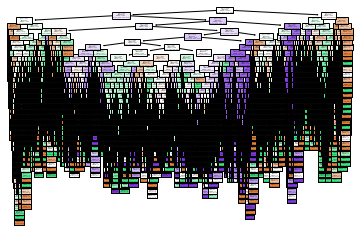

In [27]:
tree.plot_tree(raw_DTC, filled=True)

## 5.5. Post Pruning Decision Tree Classifier

### 5.5.1. Total impurity of leaves vs effective alphas of pruned tree

The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [28]:
path = raw_DTC.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

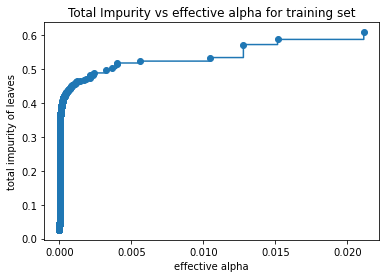

In [29]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

We train a decision tree using the effective alphas. The last value in `ccp_alphas` is the alpha value that prunes the whole tree, leaving the tree, `classifiers[-1]`, with one node.

```
classifiers = []
for ccp_alpha in ccp_alphas:
    classifier = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    classifier.fit(x_train, y_train)
    classifiers.append(classifier)
```

 We remove the last element in `classifiers` and `ccp_alphas`, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

```
classifiers = classifiers[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [classifier.tree_.node_count for clf in classifiers]
depth = [classifier.tree_.max_depth for clf in classifiers]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
```


When `ccp_alpha` is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and 88% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, setting ccp_alpha=0.015 maximizes the testing accuracy.


```
train_scores = [classifier.score(x_train, y_train) for clf in classifiers]
test_scores = [classifier.score(x_test, y_test) for clf in classifiers]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

```

### 5.5.2. Tunning the Hyper parameters

In [35]:
from sklearn.model_selection import GridSearchCV

In [34]:
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,32,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'splitter' : ['best', 'random']
    
}

In [38]:
grid_DTC = GridSearchCV(estimator=raw_DTC,param_grid=grid_param,cv=5)

In [39]:
grid_DTC.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 32),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'splitter': ['best', 'random']})

In [41]:
grid_DTC.best_estimator_

DecisionTreeClassifier(max_depth=19, min_samples_leaf=9, min_samples_split=5)

### 5.5.3. Tunned Model

Building the tunned model with best found parameters for `raw_DTC`

In [42]:
tunned_DTC = DecisionTreeClassifier(max_depth=19, min_samples_leaf=9, min_samples_split=5)

In [43]:
tunned_DTC.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=19, min_samples_leaf=9, min_samples_split=5)

## 5.6. Performance Metrics

### 5.6.1. Raw DTC

In [57]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [44]:
y_predict_raw_DTC = raw_DTC.predict(scaler.transform(x_test))

In [54]:
accuracy_score(y_predict_raw_DTC, y_test)

0.6652505446623094

In [55]:
print(classification_report(y_predict_raw_DTC, y_test))

              precision    recall  f1-score   support

           1       0.60      0.58      0.59     15654
           2       0.59      0.59      0.59     15269
           3       0.81      0.83      0.82     14977

    accuracy                           0.67     45900
   macro avg       0.67      0.67      0.67     45900
weighted avg       0.66      0.67      0.66     45900



### 5.6.2. Tunned DTC

In [58]:
y_predict_tunned_DTC = tunned_DTC.predict(scaler.transform(x_test))

In [59]:
accuracy_score(y_predict_tunned_DTC, y_test)

0.702723311546841

In [60]:
print(classification_report(y_predict_tunned_DTC, y_test))

              precision    recall  f1-score   support

           1       0.61      0.65      0.63     14401
           2       0.64      0.62      0.63     15713
           3       0.86      0.84      0.85     15786

    accuracy                           0.70     45900
   macro avg       0.70      0.70      0.70     45900
weighted avg       0.71      0.70      0.70     45900



# 6. Pickling

In [61]:
import pickle

In [62]:
DTC = pickle.dump(raw_DTC, open('raw_DTC_model.sav', 'wb'))

In [63]:
TDTC = pickle.dump(tunned_DTC, open('tunned_DTC_model.sav', 'wb'))